# t-distributed Stochastic Neighbor Embedding (tSNE)

### What Is t-SNE?

t-SNE is a **non-linear** dimensionality-reduction technique that turns very high-dimensional data into a 2-D or 3-D map in which points that were close together in the original space stay close, while distant points move apart. 

The idea: preserve **local neighborhoods** by matching pair-wise *similarity probabilities* in the high-dimensional space with those in the low-dimensional map, then minimizing the difference between the two probability distributions.

---

### How It Works

Conceptual algorithm:

1. **Compute similarities**:
   *For every pair of samples* convert Euclidean distances into conditional probabilities

   $$
   p_{j|i}=\frac{\exp(-\lVert x_i-x_j\rVert^{2}/2\sigma_i^{2})}{\sum_{k\neq i}\exp(-\lVert x_i-x_k\rVert^{2}/2\sigma_i^{2})},
   $$

   where the bandwidth $\sigma_i$ is chosen so each point has a user-defined **perplexity** (~ effective number of neighbors).

2. **Symmetrize**: to get joint probabilities $p_{ij}$.

3. **Initialize** low-dimensional points $y_i$ at random.

4. **Model similarities** in the map with a heavy-tailed Student-t distribution with one degree of freedom

   $$
   q_{ij}=\frac{(1+\lVert y_i-y_j\rVert^{2})^{-1}}{\sum_{k\neq l}(1+\lVert y_k-y_l\rVert^{2})^{-1}}.
   $$

5. **Minimize** the Kullback–Leibler divergence

   $$
   \text{KL}(P\|Q)=\sum_{i\neq j} p_{ij}\log\frac{p_{ij}}{q_{ij}}
   $$

   via gradient descent, often starting with an **early-exaggeration** phase that temporarily multiplies all $p_{ij}$ to tease clusters apart.

6. **Iterate** until the map stabilizes (a few hundred to a few thousand steps).

---

### Pros and Cons

✅ Uncovers **non-linear structure**   
✅ **Few knobs** to tune (perplexity, learning-rate).  
✅ Works on images, word embeddings, gene-expression data, etc.  

❌ Axes have **no quantitative meaning**; distances across points are unreliable.  
❌ **Non-convex**: not ideal for strict reproducibility.  
❌ Computational cost grows quickly 

---

### Key Hyper-parameters

| Symbol in `sklearn`  | Meaning                             | Typical starter value |
| -------------------- | ----------------------------------- | --------------------- |
| `perplexity`         | Effective neighborhood size         | 30 (range 5 – 50)     |
| `learning_rate`      | Gradient-descent step size          | 200                   |
| `n_iter`             | Total iterations                    | 1000                  |
| `early_exaggeration` | Separation boost in first 250 steps | 12                    |

---

In [1]:
# Loading data
import pandas as pd

#    (replace path with your own .csv or DataFrame source)
spotify = pd.read_csv("../data/spotify_track_ratings.csv")
spotify= spotify.sample(n=5_000, random_state=42)   
# ▸ Keep just numeric audio columns
num_cols = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo", "duration_ms"
]
X = spotify[num_cols].dropna()

In [6]:
# standardise input
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
X_std = StandardScaler().fit_transform(X)
seed=42
tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        random_state=seed
    ).fit_transform(X_std)

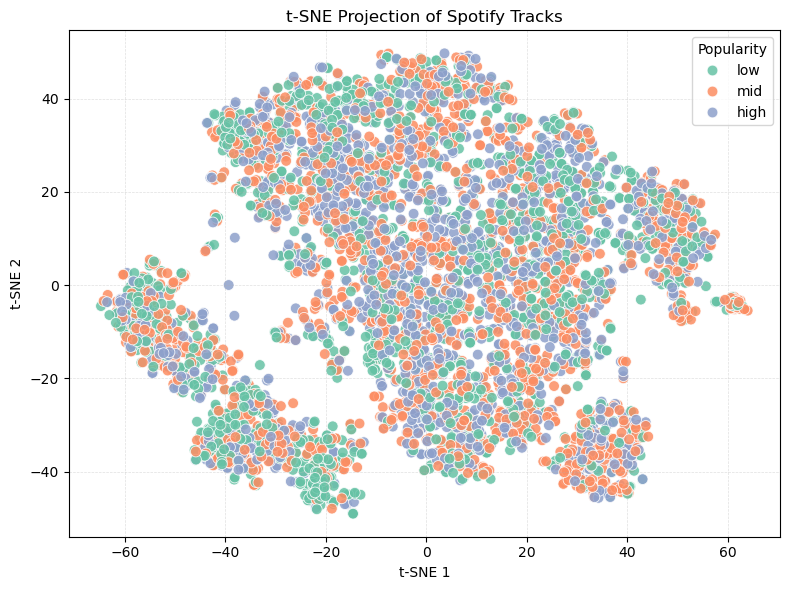

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# bin popularity (0-100) into terciles
pop = spotify.loc[X.index, "popularity"].fillna(0)
colour_label = pd.qcut(pop, 3, labels=["low", "mid", "high"])


df_tsne = pd.DataFrame(tsne, columns=["TSNE1", "TSNE2"])
df_tsne["label"] = colour_label.values          

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_tsne,
    x="TSNE1",
    y="TSNE2",
    hue="label",
    palette="Set2",
    s=60,          # marker size
    alpha=0.85
)

plt.title("t-SNE Projection of Spotify Tracks")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Popularity", loc="best", frameon=True)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
plt.tight_layout()
plt.show()
